In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
from keras.models import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

In [3]:
directory = r"C:\Users\arpit\Desktop\SAP-internal-face-mask-detection\Medical mask\Medical mask\Medical Mask\annotations"
image_directory = r"C:\Users\arpit\Desktop\SAP-internal-face-mask-detection\Medical mask\Medical mask\Medical Mask\images"
df = pd.read_csv(r"C:\Users\arpit\Desktop\SAP-internal-face-mask-detection\Medical mask\train.csv")
df_test = pd.read_csv(r"C:\Users\arpit\Desktop\SAP-internal-face-mask-detection\Medical mask\submission.csv")

In [4]:
cvNet = cv2.dnn.readNetFromCaffe(prototxt="models/deploy.prototxt",
                                            caffeModel="models/res10_300x300_ssd_iter_140000_fp16.caffemodel")
def getJSON(filePathandName):
    with open(filePathandName,'r') as f:
        return json.load(f)
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

In [5]:
df.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


In [6]:
jsonfiles= []
for i in os.listdir(directory):
    jsonfiles.append(getJSON(os.path.join(directory,i)))
jsonfiles[0]

{'FileName': '1801.jpg',
 'NumOfAnno': 1,
 'Annotations': [{'isProtected': False,
   'ID': 924868908868875136,
   'BoundingBox': [451, 186, 895, 697],
   'classname': 'face_no_mask',
   'Confidence': 1,
   'Attributes': {}}]}

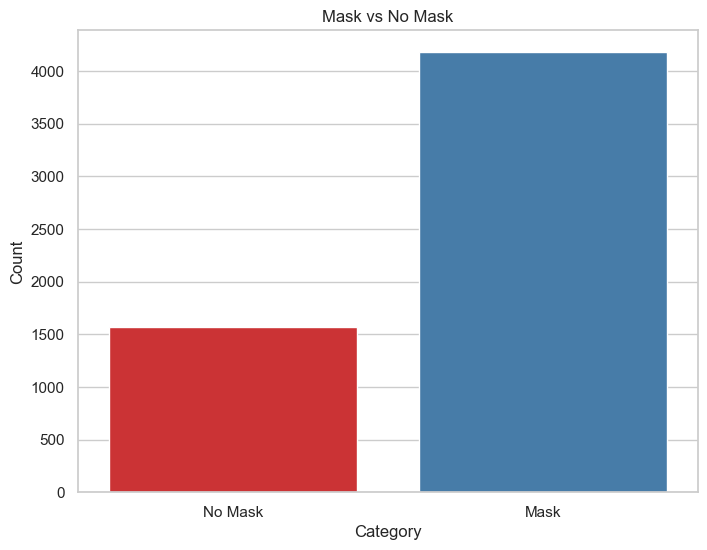

In [7]:
data = []
img_size = 124
mask = ['face_with_mask']
non_mask = ["face_no_mask"]
labels={'mask':0,'without mask':1}
for i in df["name"].unique():
    f = i+".json"
    for j in getJSON(os.path.join(directory,f)).get("Annotations"):
        if j["classname"] in mask:  
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))
            data.append([img,labels["mask"]])
        if j["classname"] in non_mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size)) 
            data.append([img,labels["without mask"]])
random.shuffle(data)

p = []
for face in data:
    if face[1] == 0:
        p.append("Mask")
    else:
        p.append("No Mask")

# Create a count plot using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.countplot(x=p, palette="Set1")
plt.title("Mask vs No Mask")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()
p=[]

In [8]:
X = []
Y = []

for features, label in data:
    X.append(features)
    Y.append(label)

X = np.array(X) / 255.0
X = X.reshape(-1, 124, 124, 3)
Y = np.array(Y)

In [9]:
# Check if there are GPUs available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

# Check which GPU is being used (if any)
print("Available GPUs:")
for device in tf.config.experimental.list_physical_devices('GPU'):
    print(device.name)

GPU is available
Available GPUs:
/physical_device:GPU:0


In [10]:
"""model = Sequential()

model.add(Conv2D(32, (3, 3), padding="same", activation='relu', input_shape=(124, 124, 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))

model.add(Dense(1, activation='sigmoid'))# OUTPUT

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

xtrain, xval, ytrain, yval = train_test_split(X, Y, train_size=0.8, random_state=0)

datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
)

datagen.fit(xtrain)

history = model.fit(
    datagen.flow(xtrain, ytrain, batch_size=32),
    steps_per_epoch=xtrain.shape[0] // 32,
    epochs=25,
    verbose=1,
    validation_data=(xval, yval)
)"""

'model = Sequential()\n\nmodel.add(Conv2D(32, (3, 3), padding="same", activation=\'relu\', input_shape=(124, 124, 3)))\nmodel.add(Conv2D(64, (3, 3), activation=\'relu\'))\nmodel.add(Conv2D(128, (3, 3), activation=\'relu\'))\nmodel.add(MaxPooling2D(pool_size=(2, 2)))\nmodel.add(Dropout(0.25))\nmodel.add(Flatten())\nmodel.add(Dropout(0.5))\nmodel.add(Dense(64, activation=\'relu\'))\n\nmodel.add(Dense(1, activation=\'sigmoid\'))# OUTPUT\n\nmodel.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n\nxtrain, xval, ytrain, yval = train_test_split(X, Y, train_size=0.8, random_state=0)\n\ndatagen = ImageDataGenerator(\n    featurewise_center=False,\n    samplewise_center=False,\n    featurewise_std_normalization=False,\n    samplewise_std_normalization=False,\n    zca_whitening=False,\n    rotation_range=15,\n    width_shift_range=0.1,\n    height_shift_range=0.1,\n    horizontal_flip=True,\n    vertical_flip=False\n)\n\ndatagen.fit(xtrain)\n\nhistory = model.fit

model.save("my_model.h5")

In [ ]:
"""model.save("my_model.h5")"""

In [11]:
#### To load a saved model, you can use the following code
loaded_model = tf.keras.models.load_model("my_model.h5")

1/1 [==============================] - 0s 20ms/step


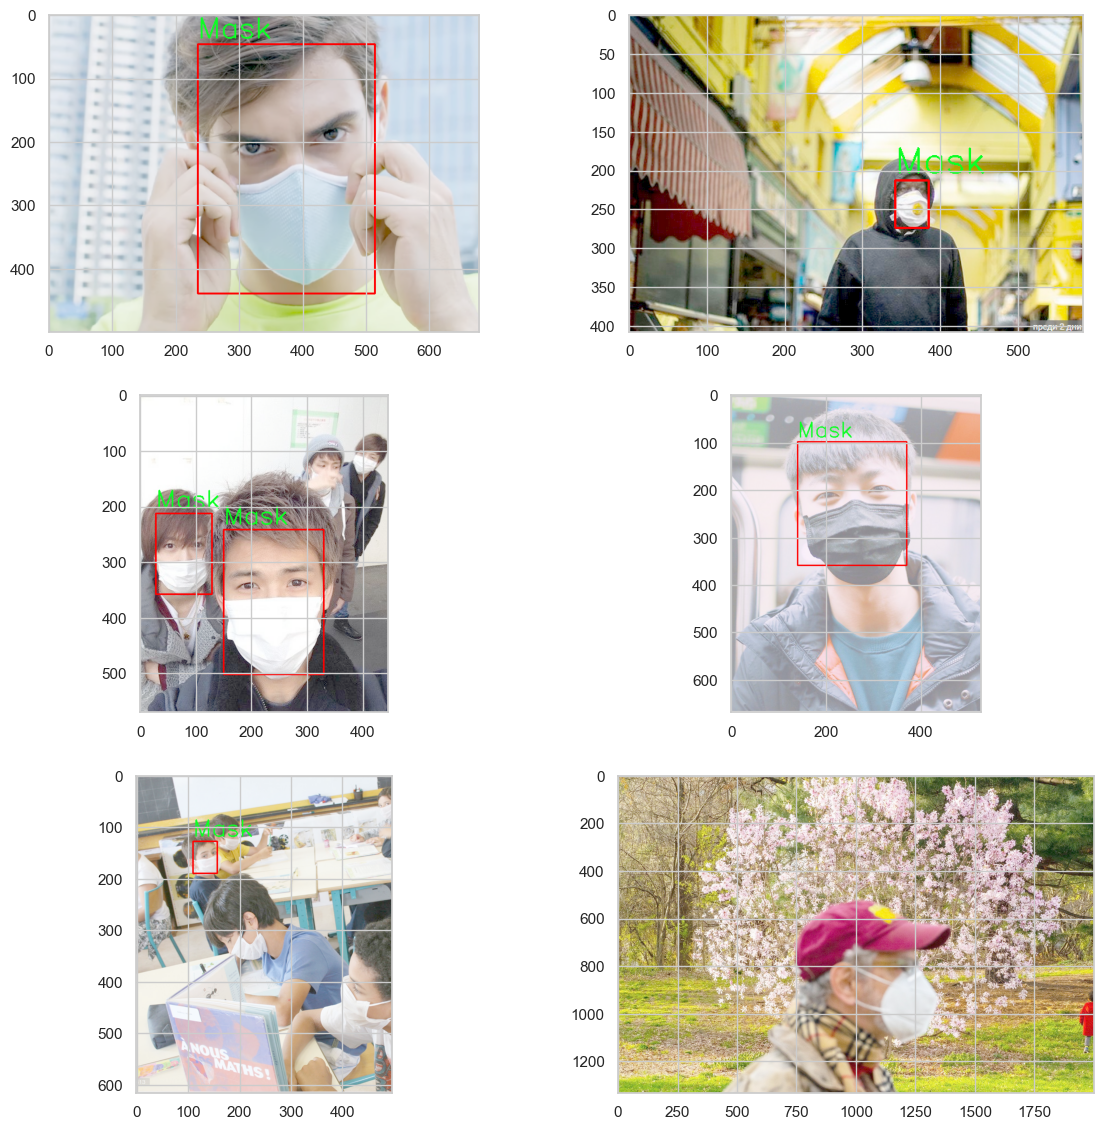

In [93]:
num_test_images = 6  # Change this to the number of random image names you want to select
test_images = df['name'].sample(n=num_test_images, random_state=27).tolist()

gamma = 2.2 # the gamma value for adjusting image brightness
conf_threshold = 0.7  # the confidence threshold
nms_threshold = 0.2  # the NMS threshold

fig = plt.figure(figsize=(14, 14))
rows = 3
cols = 2
axes = []
assign = {'0': 'Mask', '1': "No Mask"}
for j, im in enumerate(test_images):
    image = cv2.imread(os.path.join(image_directory, im), 1)
    
    # Adjust gamma for better visibility
    image = adjust_gamma(image, gamma=gamma)
    
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    cvNet.setInput(blob)
    detections = cvNet.forward()

    # Use NMS to filter out overlapping and low-confidence bounding boxes
    indices = cv2.dnn.NMSBoxes(detections[0, 0, :, :4], detections[0, 0, :, 2], conf_threshold, nms_threshold)

    for i in range(len(indices)):
        index = indices[i]  # Get the index from indices
        box = detections[0, 0, index, 3:7] * np.array([w, h, w, h])
        confidence = detections[0, 0, index, 2]

        # Check if confidence is above threshold and box coordinates are valid
        if confidence > conf_threshold:
            (startX, startY, endX, endY) = box.astype("int")
            frame = image[startY:endY, startX:endX]

            im = cv2.resize(frame, (img_size, img_size))
            im = np.array(im) / 255.0
            im = im.reshape(1, 124, 124, 3)

            try:
                result = model.predict(im)
            except:
                result = loaded_model.predict(im)

            if result >= 0.7:
                label_Y = 1
            else:
                label_Y = 0

            cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
            cv2.putText(image, assign[str(label_Y)], (startX, startY - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.5, (36, 255, 12), 2)

    axes.append(fig.add_subplot(rows, cols, j + 1))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()
